In [8]:
import numpy as np
import optuna
from sklearn import metrics
import warnings
import pickle
warnings.simplefilter(action='ignore', category=FutureWarning)
import joblib
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, r2_score, roc_curve
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [9]:
# Load the data
data = np.load('DataSet/Classified_Data.npz')

Features = data['features']

Labels = data['labels']

print(Features.shape, Labels.shape)

(16871, 9) (16871,)


In [10]:
# 分割数据集为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(Features, Labels, test_size=0.2, random_state=42)

# 创建 LightGBM 数据集
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [11]:
# 设置 XGBoost 参数
params = {
    'objective': 'binary:logistic',  # 二分类问题，输出概率
    'eval_metric': 'logloss',  # 评估指标为对数损失
    'booster': 'gbtree',  # 使用基于树的模型
    'max_depth': 5,  # 树的最大深度
    'eta': 0.01,  # 学习率
    'subsample': 0.8,  # 数据的子抽样比例
    'colsample_bytree': 0.9,  # 特征的子抽样比例
    'scale_pos_weight': sum(y_train == 0) / sum(y_train == 1),  # 用于处理不平衡数据
}

# 训练模型
evals = [(dtrain, 'train'), (dtest, 'eval')]
bst = xgb.train(
    params, 
    dtrain, 
    num_boost_round=5000, 
    evals=evals, 
    early_stopping_rounds=50
    )

[0]	train-logloss:0.68666	eval-logloss:0.68671
[1]	train-logloss:0.68028	eval-logloss:0.68040
[2]	train-logloss:0.67401	eval-logloss:0.67420
[3]	train-logloss:0.66784	eval-logloss:0.66817
[4]	train-logloss:0.66180	eval-logloss:0.66222
[5]	train-logloss:0.65587	eval-logloss:0.65640
[6]	train-logloss:0.65081	eval-logloss:0.65130
[7]	train-logloss:0.64521	eval-logloss:0.64582
[8]	train-logloss:0.64027	eval-logloss:0.64090
[9]	train-logloss:0.63520	eval-logloss:0.63592
[10]	train-logloss:0.62993	eval-logloss:0.63068
[11]	train-logloss:0.62453	eval-logloss:0.62539
[12]	train-logloss:0.61994	eval-logloss:0.62081
[13]	train-logloss:0.61542	eval-logloss:0.61628
[14]	train-logloss:0.61099	eval-logloss:0.61187
[15]	train-logloss:0.60595	eval-logloss:0.60694
[16]	train-logloss:0.60169	eval-logloss:0.60268
[17]	train-logloss:0.59683	eval-logloss:0.59793
[18]	train-logloss:0.59246	eval-logloss:0.59370
[19]	train-logloss:0.58788	eval-logloss:0.58921
[20]	train-logloss:0.58322	eval-logloss:0.58468
[2

In [12]:
import os
directory = "Classification/"
xgb_model_path = os.path.join(directory, "xgb_model.json")  # 使用 JSON 格式保存
bst.save_model(xgb_model_path)

In [13]:
# 创建 XGBoost 需要的 DMatrix 数据结构，因为 XGBoost 的预测函数需要这个格式的输入
dtrain_pred = xgb.DMatrix(X_train)

# 使用最佳迭代次数来进行预测，得到的是概率结果
y_pred_prob = bst.predict(dtrain_pred, iteration_range=(0, bst.best_iteration + 1))
# 将概率转换为二进制输出
y_pred = (y_pred_prob >= 0.5).astype(int)

# 输出分类报告和准确度
print(classification_report(y_train, y_pred))
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      7592
           1       0.89      0.97      0.93      5904

    accuracy                           0.93     13496
   macro avg       0.93      0.94      0.93     13496
weighted avg       0.94      0.93      0.93     13496

Accuracy: 0.9339804386484885


In [14]:
# 创建 XGBoost 需要的 DMatrix 数据结构，因为 XGBoost 的预测函数需要这个格式的输入
dtrain_pred = xgb.DMatrix(X_test)

# 使用最佳迭代次数来进行预测，得到的是概率结果
y_pred_prob = bst.predict(dtrain_pred, iteration_range=(0, bst.best_iteration + 1))
# 将概率转换为二进制输出
y_pred = (y_pred_prob >= 0.5).astype(int)

# 输出分类报告和准确度
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

              precision    recall  f1-score   support

           0       0.94      0.88      0.91      1872
           1       0.86      0.93      0.89      1503

    accuracy                           0.90      3375
   macro avg       0.90      0.90      0.90      3375
weighted avg       0.90      0.90      0.90      3375

Accuracy: 0.9016296296296297


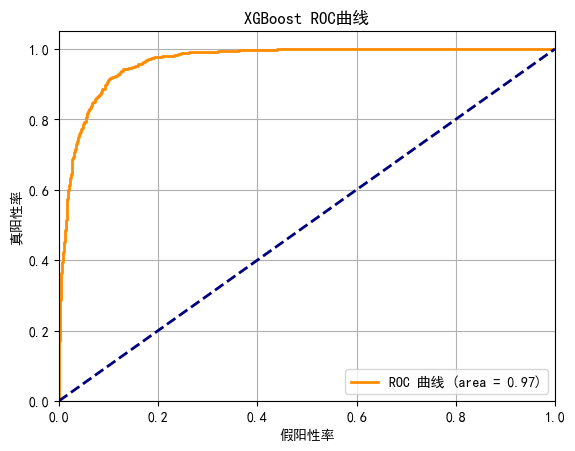

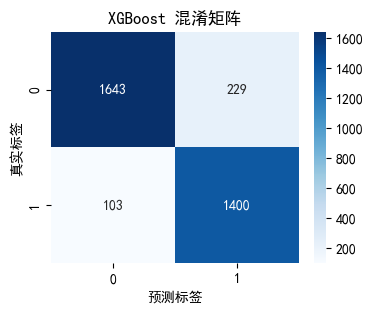

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
# 计算 ROC 曲线的 FPR（假阳性率）和 TPR（真阳性率）
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)  # 注意: y_pred_prob 需要是预测为正类的概率
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC 曲线 (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.title('XGBoost ROC曲线')
plt.legend(loc="lower right")
plt.grid()
plt.show()


# 计算混淆矩阵
cm = confusion_matrix(y_test, y_pred)

# 使用 Seaborn 绘图
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('XGBoost 混淆矩阵')
plt.xlabel('预测标签')
plt.ylabel('真实标签')
plt.show()